In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats 

In [2]:
# set random seed
np.random.seed(123)

In [3]:
# parameters definition
sigma = 0.2
r = .03
K = 100
S_0 = 100
T = 1
N=100

# other parameters used in the question
mean = 0
std = 1  # std of normal distribution 

### Q1 - Tracer le prix de l’option asiatique en fonction de $S_0$ . Comparer au prix du call européen de mêmes strike et maturité

Dans cette question nous voulons tracer le prix de l'option asiatique pour une maturité $T=1$. Nous définissons donc des valeurs de T et de $S_0$ que nous voudrions tester.

In [4]:
# parameters for the question 

# collection of S_0 to experiments
s_0 = np.linspace(0, 1.5*K, 100)
num_sim = 1000  # num of monte carlo simulatioon

Avant de calculer le prix du call asiatique, nous voulons générer les $(S_t)_{t>0}$. Pour cela, nous utilisons la formule suivante: 

$$ S_{t_i} = S_{t_i} \times e^{(r - \frac{\sigma^2}{2})(t_i - t_{i-1}) + \sigma ( B^{Q}_{t_i} - B^{Q}_{t_{i-1}}) } $$ 

Pour cela, remarquons que $ B^{Q}_{t_i} - B^{Q}_{t_{i-1}} \sim N(0, t_i - t_{i-1}) $. 

De plus, nous supposons dans toute cette partie que pour tout $i \in [1, N]$, on a $t_i - t_{i-1} = 1/N$. Autrement dit, nous supposons que notre suite $(t_i)$ est de pas constant.   

In [5]:
# generate a path realisation of St for 0<=t<=T

def path_generation(num_sim, N, S0, r, sigma):
    """
    This function create a realisation of a path S_t depending
    on t_0, t_1, ..., t_N. Difference between t_(i+1) and t_i is 
    supposed to be constant and equal to 1/N. N is given as input.

    :params num_sim: int
        Number of simulation for monte carlo
    :params N: inverse of t_(i+1) - t_i
        Table of t_i moments in asian call definition
    :params S0: float
        Initial vlaue of S (S(t=0))
    :params r: float
        Rate
    :params sigma: float
        Volatility
    :return S: np.array(shape=(1, N+1))
        Path S generated by the function 
    """ 

    # define difference of brownian motions    
    brownian_motion = np.random.normal(loc=mean, scale=np.sqrt(T/N), size=(num_sim, N))

    # initialization of S
    S = np.zeros(shape=(num_sim, N+1))
    S[:, 0] = S0

    # compute S(t_i) using S(t_i-1)
    for i in range(N):

        # exponential argument
        exp_arg = T/N * (r - (sigma**2)/2) + sigma * brownian_motion[:, i]

        S[:, i+1] = S[:, i] * np.exp(exp_arg)

    return S

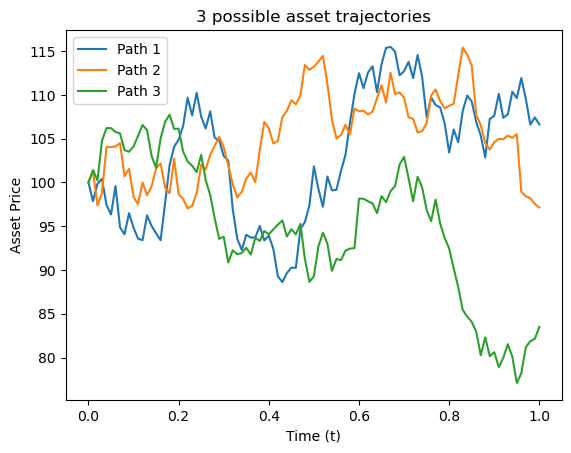

In [6]:
# generate 3 paths
S1 = path_generation(1, N, S_0, r, sigma)
S2 = path_generation(1, N, S_0, r, sigma)
S3 = path_generation(1, N, S_0, r, sigma)

# plot of 3 trajectories
plt.plot(np.linspace(0, T, N+1), S1[0, :], label='Path 1')
plt.plot(np.linspace(0, T, N+1), S2[0, :], label='Path 2')
plt.plot(np.linspace(0, T, N+1), S3[0, :], label='Path 3')

# add legend
plt.xlabel("Time (t)")
plt.ylabel('Asset Price')
plt.title("3 possible asset trajectories")
plt.legend()

plt.show()

Nous pouvons ainsi visualiser quelques trajectoires possibles pour $S_t$.

Désormais, nous sommes capables de générer des trajectoires $(S_t)$. Nous voulons maintenant calculer le prix de l'option asiatique grâce à la formule:

$$ C_T = e^{-rT} \times (\frac{1}{N}\sum^{N}_{i=1} - K)_+ $$ 

In [7]:
# compute price of asian call 

def price_asian_call(num_sim, N, S0, r, sigma, T, K,**kwargs):
    """
    Function computing the asian call price.

    :params num_sim: int
        Number of simulation for monte carlo
    :params S: 
        Sequence of S_0, S_t1, ..., S_T
    :params r: float
        Rate
    :params T:
        Maturity 
    :params K:
        Strike
    """  
    S = path_generation(num_sim, N, S0, r, sigma)
    mean_S = np.mean(S[:, 1:], axis=1)  # S_0 is removed
    return np.exp(-r*T) * np.maximum(mean_S - K, np.zeros_like(mean_S))

In [8]:
def price_european_call(S_0=S_0, T=T, sigma=sigma, r=r, K=K):
    """
    phi function used to compute european call price

    :params x: 
        variable of phi function
    :params s_0: float
        Asset value at t=0
    :params T: float
        Maturity 
    :params sigma: float
        volatility
    :params r: float
        # to define
    :params K: float
        Strike
    """
    # compute value in exponential
    d1 = np.divide((np.log(S_0/K) + (r + (sigma**2)/2) * T) , (sigma*np.sqrt(T))+1e-6)
    d2 = d1 - sigma*np.sqrt(T)
    price = S_0*stats.norm.cdf(d1, loc=0, scale=1) \
             - K * np.exp(-r*T)*stats.norm.cdf(d2, loc=0, scale=1)
    
    return price

In [9]:
# final plots
asian_plots = np.zeros(len(s_0))
asian_plots_N_1 = np.zeros(len(s_0))
european_plots = np.zeros(len(s_0))

# compute values
for i, s in enumerate(s_0):
        # compute phi for each sample
        asian_plots[i] = np.mean(price_asian_call(num_sim, N, s, r, sigma, T, K))
        asian_plots_N_1[i] = np.mean(price_asian_call(num_sim, 1, s, r, sigma, T, K)) # N=1
        european_plots[i] = price_european_call(s, T, sigma, r, K)

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_11078/1402114522.py:19: RuntimeWarning: divide by zero encountered in log
  d1 = np.divide((np.log(S_0/K) + (r + (sigma**2)/2) * T) , (sigma*np.sqrt(T))+1e-6)


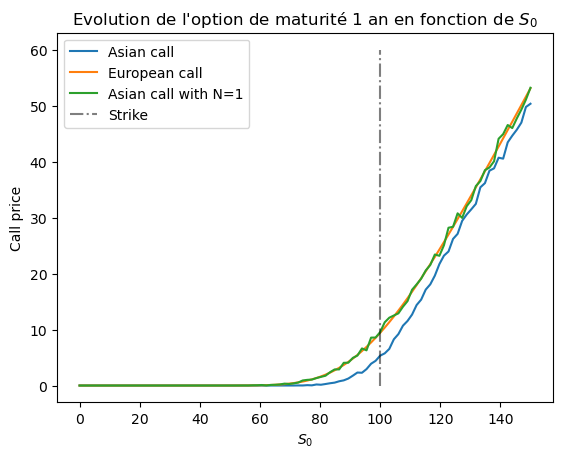

In [10]:
plt.plot(s_0, asian_plots, label=f"Asian call")
plt.plot(s_0, european_plots, label=f"European call")
plt.plot(s_0, asian_plots_N_1, label=f"Asian call with N=1")


# add strike on the plot
plt.vlines(x=K, ymin=0., ymax=60., color="black",
           label="Strike", linestyles="dashdot", alpha=.5)

# add legend
plt.title("Evolution de l'option de maturité 1 an en fonction de $S_0$")
plt.legend()
plt.xlabel("$S_0$")
plt.ylabel("Call price")
plt.show()

Enfin, nous pouvons visualiser le prix de l'option asiatique pour différentes valeurs de $S_0$ et de $T$.Pour N=1, on retrouve bien le tracé du prix d'un call européen ayant les mêmes paramètres que celui de notre call asiatique.

En outre, nous pouvons constater que dans nos conditions, le call asiatique apparait moins cher que le call européen.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_11078/1402114522.py:19: RuntimeWarning: divide by zero encountered in log
  d1 = np.divide((np.log(S_0/K) + (r + (sigma**2)/2) * T) , (sigma*np.sqrt(T))+1e-6)


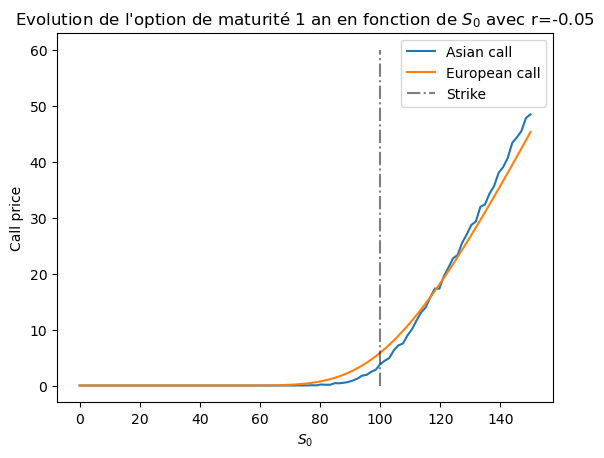

In [11]:
# Cas où les taux seraient négatifs. Ceci est possible en cas de dividendes et de taux de repo élevés

r_neg=-0.05  

# final plots
asian_plots = np.zeros(len(s_0))
european_plots = np.zeros(len(s_0))



# compute values
for i, s in enumerate(s_0):
        # compute phi for each sample
        asian_plots[i] = np.mean(price_asian_call(num_sim, N, s, r_neg, sigma, T, K))
        european_plots[i] = price_european_call(s, T, sigma, r_neg, K)

# plot of price for several maturities
plt.plot(s_0, asian_plots, label=f"Asian call ")
plt.plot(s_0, european_plots, label=f"European call")


# add strike on the plot
plt.vlines(x=K, ymin=0., ymax=60., color="black",
           label="Strike", linestyles="dashdot", alpha=.5)

# add legend
plt.title("Evolution de l'option de maturité 1 an en fonction de $S_0$ avec r=-0.05")
plt.legend()
plt.xlabel("$S_0$")
plt.ylabel("Call price")
plt.show()

Il apparait que lorsqu'on est 'deep in the money', le call asiatique est bien plus chère que le call européen lorsque les taux sont négatifs.

### Q2. Etudier l'évolution du prix de l'option asiatique en fonction de N.

Dans cette question, on veut évaluer l'évolution du prix de l'option asiatique en fonction du nombre de dates d'observations N:

In [12]:
# parameters for the question 
N_values = np.linspace(1, 252, num=252)


In [13]:
# final plots
plots_q2 = np.zeros(len(N_values))

# compute values
for i, N_ in enumerate(N_values):
        # compute phi for each sample
        plots_q2[i] = np.mean(price_asian_call(num_sim, int(N_), S_0, r, sigma, T, K))


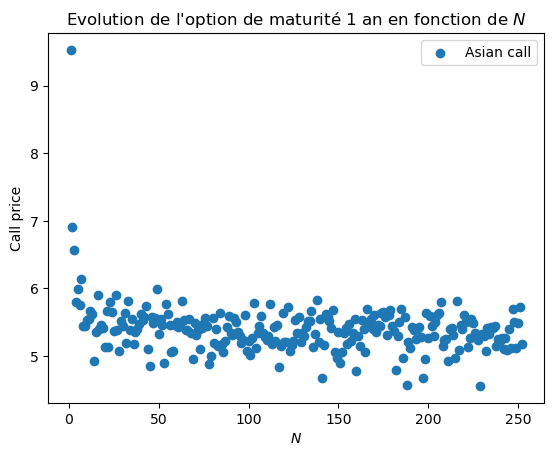

In [14]:
# plot of price for several maturities
plt.scatter(x=N_values,y=plots_q2,label=f"Asian call")

# add legend
plt.title("Evolution de l'option de maturité 1 an en fonction de $N$")
plt.legend()
plt.xlabel("$N$")
plt.ylabel("Call price")
plt.show()

Pour N=1, nous obtenons la valeur la plus élevée. C'est normal puisque pour N=1, notre call asiatique est un call européen et dans nos conditions, call européen est plus chère que call asiatique. Ensuite, pour N>1, le prix diminue et il semble qu'il y ait une sorte de convergence du prix de l'option d'achat asiatique vers ~5.4, à partir de N=20. 

### Q3. Analyse des performances des méthodes de réduction de variance pour le pricing d’une option asiatique : méthodes de variables antithétique

Si $U \sim U(0,1)$ alors la variable $1-U$ suit également une loi uniforme sur $[0,1]$. Le principe de la méthode des variables antithétiques est de tirer parti de cette symétrie. Cette technique permet de générer deux variables à partir d'un tirage, et est particulièrement avantageuse si le tirage est coûteux. Néanmoins pour évaluer son efficacité, il faut comparer avec une méthode de Monte-Carlo avec $2n$ tirages.

On peut montrer que cela permet de supprimer la variance liée à la partie impaire du payoff, on s'attend donc à ce qu'un Monte-Carlo avec variable antithétique à $n$ tirage ait toujours une variance plus faible qu'un Monte-Carlo classique à $2n$ tirages.

On commence par afficher l'évolution de l'estimation du prix du call asiatique en fonction du nombre d'itération pour constater celui qui converge le plus rapidement. L'estimation avec variable antithétique n'est mise à jour qu'une itération sur deux pour être équitable avec l'estimation classique.

In [15]:
# generate a path realisation for the antithetic case S(N(0,1)) et S(-N(0,1)) for 0<=t<=T

def path_generation_antithetique(num_sim, N, S0, r, sigma):
    """
    This function create a realisation of a path S_t depending
    on t_0, t_1, ..., t_N. Difference between t_(i+1) and t_i is 
    supposed to be constant and equal to 1/N. N is given as input.

    :params num_sim: int
        Number of simulation for monte carlo
    :params N: inverse of t_(i+1) - t_i
        Table of t_i moments in asian call definition
    :params S0: float
        Initial vlaue of S (S(t=0))
    :params r: float
        Rate
    :params sigma: float
        Volatility
    :return S: np.array(shape=(1, N+1))
        Path S generated by the function 
    """ 

    # define difference of brownian motions    
    brownian_motion = np.random.normal(loc=mean, scale=np.sqrt(T/N), size=(num_sim, N))

    brownian_motion_moins=-brownian_motion
    # initialization of S
    S = np.zeros(shape=(num_sim, N+1))
    S_moins = np.zeros(shape=(num_sim, N+1))
    S[:, 0] = S0
    S_moins[:, 0] = S0
    # compute S(t_i) using S(t_i-1)
    for i in range(N):

        # exponential argument
        exp_arg = T/N * (r - (sigma**2)/2) + sigma * brownian_motion[:, i]

        S[:, i+1] = S[:, i] * np.exp(exp_arg)

        exp_arg_moins = T/N * (r - (sigma**2)/2) + sigma * brownian_motion_moins[:, i]

        S_moins[:, i+1] = S_moins[:, i] * np.exp(exp_arg_moins)
        

    return S , S_moins

In [16]:
# compute price of asian call 

def price_asian_call_antithetique(num_sim, N, S0, r, sigma, T, K,**kwargs):
    """
    Function computing the asian call price.

    :params num_sim: int
        Number of simulation for monte carlo
    :params S: 
        Sequence of S_0, S_t1, ..., S_T
    :params r: float
        Rate
    :params T:
        Maturity 
    :params K:
        Strike
    """  
    
    S,S_moins= path_generation_antithetique(num_sim, N, S0, r, sigma)
    mean_S = np.mean(S[:, 1:], axis=1)  # S_0 is removed
    mean_moins_S = np.mean(S_moins[:, 1:], axis=1)  # S_0 is removed
    h_X=np.exp(-r*T) * np.maximum(mean_S - K, np.zeros_like(mean_S)) 
    h_X_moins= np.exp(-r*T) * np.maximum(mean_moins_S - K, np.zeros_like(mean_moins_S))
    correl=np.corrcoef(h_X,h_X_moins)[0][1]
    return (h_X+h_X_moins)/2,correl

In [17]:
nb_estimations=1000
asian_plots = np.zeros(nb_estimations)

asian_antithetique_plots = np.zeros(nb_estimations)
correl=np.zeros(nb_estimations)



# compute values
for i in range(nb_estimations):
        # compute phi for each sample
        asian_plots[i] = np.mean(price_asian_call(2*num_sim, N, S_0, r, sigma, T, K))
        result=price_asian_call_antithetique(num_sim, N, S_0, r, sigma, T, K)
        asian_antithetique_plots[i],correl[i] = np.mean(result[0]),result[1]


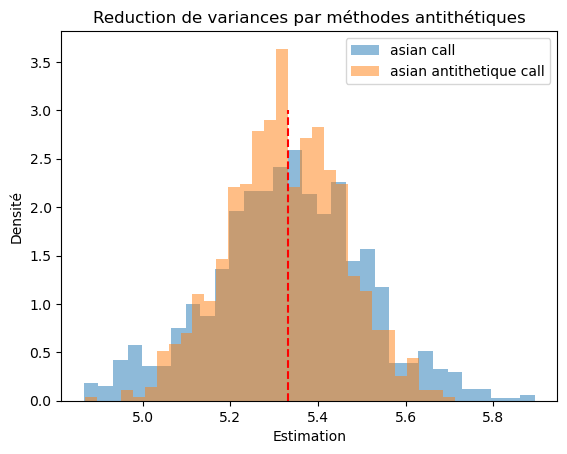

In [18]:
# ditribution of estimator
nb_bins = int(np.floor(np.sqrt(nb_estimations)))  # rule of thumb for nb of bins
plt.hist(asian_plots, bins=nb_bins, density=True,label='asian call',alpha=0.5)
plt.hist(asian_antithetique_plots, bins=nb_bins, density=True,label='asian antithetique call',alpha=0.5)
 
# add the mean
plt.vlines(x=np.mean(asian_plots), ymin=0, ymax=3,
           linestyles="dashed", color='red',
#            label="Mean: round(np.mean(estimations), 2)"
          )
 
# add legend
plt.title(f"Reduction de variances par méthodes antithétiques")
plt.xlabel('Estimation')
plt.ylabel('Densité')
plt.legend()
# plt.legend([f"Mean: {round(np.mean(asian_plots), 2)}", f"Std: {round(np.std(asian_plots), 2)}"])
plt.show()


In [19]:
np.var(asian_antithetique_plots)/np.var(asian_plots)

0.5699780806703183

In [20]:
1+np.mean(correl)

0.53187599801096

On observe bien une réduction de la variance de nos estimateurs. On retrouve bien le fait que soit $\frac{V[{\text{Cc}}]}{V[{\text{Cx}}]}$= ${1 + \rho_{(h(X), h(-X))}}$


### Q3. Analyse des performances des méthodes de réduction de variance pour le pricing d’une option asiatique : méthodes de variables de contrôle

Lorsqu'on cherche à estimer l'espérance d'une variable aléatoire $X$, on a parfois facilement accès à l'espérance d'une autre variable aléatoire $Y$ qui est corrélée à $X$. L'idée est alors de simuler une autre variable suivant la loi de $Y$ en plus de $X$ et de considérer le nouvel estimateur : $C_c = \frac{1}{n} \sum_{i=1}^n x_i + c(z_i - E(Z))$.

Cet estimateur reste non biaisé, mais pour un $c$ bien choisi offre une grande réduction de variance d'autant plus grande que les variables $X$ et $Y$ sont corrélées.

Nous allons comparer la performance de l'estimateur de Monte-Carlo classique avec celle de 3 autres estimateurs issus de 3 variables de contrôle différentes : 
 - $Z_1 = S_T$
 - $Z_2 = \frac{1}{N} \sum_{i=1}^N S_{t_i}$
 - $Z_3 = e^{-rT}(S_T-K)_+$
 
De même que précédemment, on fixe $S_0$ et $t$, et pour un grand nombre de $n$ différents, on calcule 10 000 fois le prix estimé avec chaque méthode, et on estime la variance de chaque méthode en fonction de $n$. 

In [21]:
def compute_compute_expectation(num_sim, N, S0, r, sigma, T, K, **kwargs):
    """
     :params num_sim: int
        Number of simulation for monte carlo
    :params S: 
        Sequence of S_0, S_t1, ..., S_T
    :params r: float
        Rate
    :params T:
        Maturity 
    :params K:
        Strike
    """  
    # Generate paths for Monte Carlo simulation
    path_to_compute_expectation = path_generation(num_sim, N, S0, r, sigma)

    # Compute expectation of S_T (asset value at maturity)
    expectation_S_T = np.mean(path_to_compute_expectation[:, -1])

    # Compute expectation of the mean of S over time
    expectation_mean_S = np.mean(np.mean(path_to_compute_expectation[:, 1:], axis=1))

    # Compute expectation of the call option payoff at maturity
    expectation_Call_ST = np.mean(np.exp(-r * T) * np.maximum(path_to_compute_expectation[:, -1] - K, np.zeros_like(path_to_compute_expectation[:, -1])))

    # Return a list containing the computed expectations
    return [expectation_S_T, expectation_mean_S, expectation_Call_ST]

list_expectation=compute_compute_expectation(20000, N, S_0, r, sigma, T, K)

In [22]:
# compute price of asian call 

def price_asian_call_control(num_sim, N, S0, r, sigma, T, K,list_expectation):
    """
    Function computing the asian call price for variance reduction with Control Variates

    :params num_sim: int
        Number of simulation for monte carlo
    :params S: 
        Sequence of S_0, S_t1, ..., S_T
    :params r: float
        Rate
    :params T:
        Maturity 
    :params K:
        Strike
    """  
    
    S= path_generation(num_sim, N, S0, r, sigma)
    S_T=S[:,-1]  
    
    mean_S = np.mean(S[:, 1:], axis=1)  # S_0 is removed
    Call_ST=np.exp(-r*T) * np.maximum(S_T - K, np.zeros_like(S_T)) 

    h_X=np.exp(-r*T) * np.maximum(mean_S - K, np.zeros_like(mean_S)) 
    
    controller=[S_T,mean_S,Call_ST]
    
    c_list=[-np.cov(h_X,control)[0][1]/np.var(control) for control in controller]
    
    correl=[np.corrcoef(h_X,Z)[0][1] for Z in controller]
    
    value=[np.mean(h_X + c_list[k]*( control-list_expectation[k])) for k,control in enumerate(controller)]
    
    return value,correl

In [23]:
nb_estimations=1000
asian_plots = np.zeros(nb_estimations)

asian_antithetique_plots = np.zeros(nb_estimations)

asian_ST_plots = np.zeros(nb_estimations)
asian_meanST_plots = np.zeros(nb_estimations)
asian_CallST_plots = np.zeros(nb_estimations)

correl_ST_plots = np.zeros(nb_estimations)
correl_meanST_plots = np.zeros(nb_estimations)
correl_CallST_plots = np.zeros(nb_estimations)





# compute values
for i in range(nb_estimations):
        # compute phi for each sample
        asian_plots[i] = np.mean(price_asian_call(num_sim, N, S_0, r, sigma, T, K))
#         asian_antithetique_plots[i] = np.mean(price_asian_call_antithetique(num_sim, N, S_0, r, sigma, T, K))
        value,correl=price_asian_call_control(num_sim, N, S_0, r, sigma, T, K,list_expectation)
        asian_ST_plots[i],asian_meanST_plots[i],asian_CallST_plots[i]=value
        correl_ST_plots[i],correl_meanST_plots[i],correl_CallST_plots[i]=correl
 



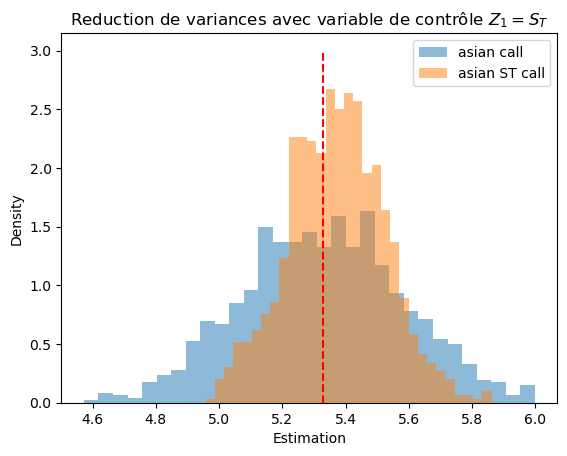

In [34]:
# ditribution of estimator using Z_1
nb_bins = int(np.floor(np.sqrt(nb_estimations)))  # rule of thumb for nb of bins
plt.hist(asian_plots, bins=nb_bins, density=True,label='asian call',alpha=0.5)
plt.hist(asian_ST_plots, bins=nb_bins, density=True,label='asian ST call',alpha=0.5)
# plt.hist(asian_meanST_plots, bins=nb_bins, density=True,label='asian meanS call',alpha=0.5)
# plt.hist(asian_CallST_plots, bins=nb_bins, density=True,label='asian CallST call',alpha=0.5)
# plt.hist(asian_antithetique_plots, bins=nb_bins, density=True,label='asian antithetique call',alpha=0.5)

# add the mean
plt.vlines(x=np.mean(asian_plots), ymin=0, ymax=3,
           linestyles="dashed", color='red',
#            label="Mean: round(np.mean(estimations), 2)"
          )
 
# add legend
plt.title("Reduction de variances avec variable de contrôle $Z_1 =S_T$ ")
plt.xlabel('Estimation')
plt.ylabel('Density')
plt.legend()
# plt.legend([f"Mean: {round(np.mean(asian_plots), 2)}", f"Std: {round(np.std(asian_plots), 2)}"])
plt.show()


In [25]:
np.var(asian_ST_plots)/np.var(asian_plots)

0.35687115812660297

In [26]:
1-np.mean(correl_ST_plots)**2

0.3714942294735255

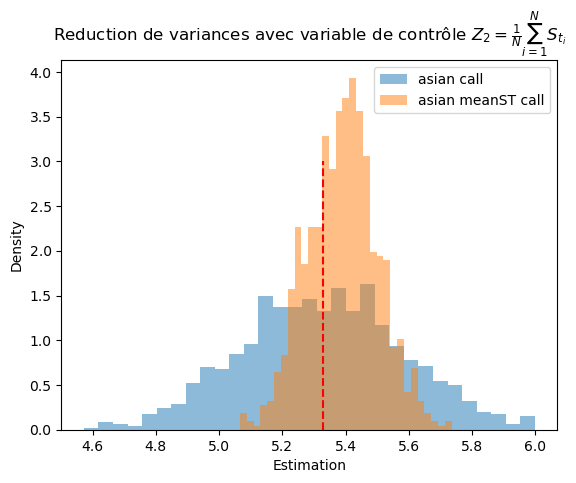

In [27]:
# ditribution of estimator using Z_2
nb_bins = int(np.floor(np.sqrt(nb_estimations)))  # rule of thumb for nb of bins
plt.hist(asian_plots, bins=nb_bins, density=True,label='asian call',alpha=0.5)
# plt.hist(asian_ST_plots, bins=nb_bins, density=True,label='asian ST call',alpha=0.5)
plt.hist(asian_meanST_plots, bins=nb_bins, density=True,label='asian meanST call',alpha=0.5)
# plt.hist(asian_CallST_plots, bins=nb_bins, density=True,label='asian CallST call',alpha=0.5)
# plt.hist(asian_antithetique_plots, bins=nb_bins, density=True,label='asian antithetique call',alpha=0.5)

# add the mean
plt.vlines(x=np.mean(asian_plots), ymin=0, ymax=3,
           linestyles="dashed", color='red',
          )
 
# add legend
plt.title(r"Reduction de variances avec variable de contrôle $Z_2=\frac{1}{N} \sum_{i=1}^N S_{t_i}$")
plt.xlabel('Estimation')
plt.ylabel('Density')
plt.legend()
# plt.legend([f"Mean: {round(np.mean(asian_plots), 2)}", f"Std: {round(np.std(asian_plots), 2)}"])
plt.show()


In [28]:
np.var(asian_meanST_plots)/np.var(asian_plots)


0.18737125807208743

In [29]:
1-np.mean(correl_meanST_plots)**2

0.18929211649794853

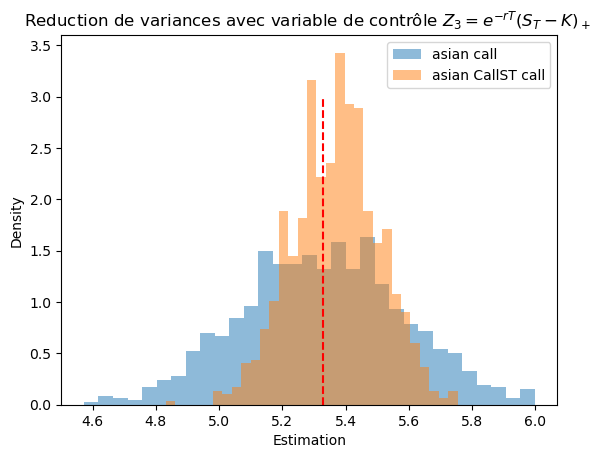

In [33]:
# ditribution of estimator using Z_3
nb_bins = int(np.floor(np.sqrt(nb_estimations)))  # rule of thumb for nb of bins
plt.hist(asian_plots, bins=nb_bins, density=True,label='asian call',alpha=0.5)
# plt.hist(asian_ST_plots, bins=nb_bins, density=True,label='asian ST call',alpha=0.5)
# plt.hist(asian_meanST_plots, bins=nb_bins, density=True,label='asian meanS call',alpha=0.5)
plt.hist(asian_CallST_plots, bins=nb_bins, density=True,label='asian CallST call',alpha=0.5)
# plt.hist(asian_antithetique_plots, bins=nb_bins, density=True,label='asian antithetique call',alpha=0.5)

# add the mean
plt.vlines(x=np.mean(asian_plots), ymin=0, ymax=3,
           linestyles="dashed", color='red',
#            label="Mean: round(np.mean(estimations), 2)"
          )
 
# add legend
plt.title("Reduction de variances avec variable de contrôle $Z_3 = e^{-rT}(S_T-K)_+$ ")
plt.xlabel('Estimation')
plt.ylabel('Density')
plt.legend()
# plt.legend([f"Mean: {round(np.mean(asian_plots), 2)}", f"Std: {round(np.std(asian_plots), 2)}"])
plt.show()


In [31]:
np.var(asian_CallST_plots)/np.var(asian_plots)

0.28385909734110204

In [32]:
1-np.mean(correl_CallST_plots)**2

0.29921252440875257

On observe bien une réduction de la variance de nos estimateurs. On retrouve bien le fait que soit $\frac{V[{\text{Cc}}]}{V[{\text{Cx}}]}$= ${1 - \rho_{(h(X), h(-X))}^2}$

D'après les courbes précédentes, il semble que la méthode de la variable de contrôle soit très efficace pour réduire la variance de nos estimateurs. Nous pouvons les classer par ordre croissant selon le facteur de réduction de variance  $\frac{1}{1 - \rho_{(h(X), h(-X))}^2}$  :

1. $Z_2 = \frac{1}{N} \sum_{i=1}^N S_{t_i}$  
2. $Z_3 = e^{-rT}(S_T-K)_+$ 
3. $Z_1= S_T$ 